# Linear Dynamical System

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.controllers import EvanBPC
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.observables import FullObservation, PartialObservation, TimeDelayedObservation
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 3
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpqy38z0bw
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpqy38z0bw/_remote_module_non_scriptable.py


## System
Here, we work with a Linear Dynamical System (LDS) with various types of perturbations.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = A x_{t} + B u_t + w_t,$$
where $A$ and $B$ are randomly generated dynamics, $u_t$ is the input control, and $w_t$ is the output of one of the below disturbance schedules.

The costs are denoted by $f(x_t, u_t)$ and given by the below cost functions.

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


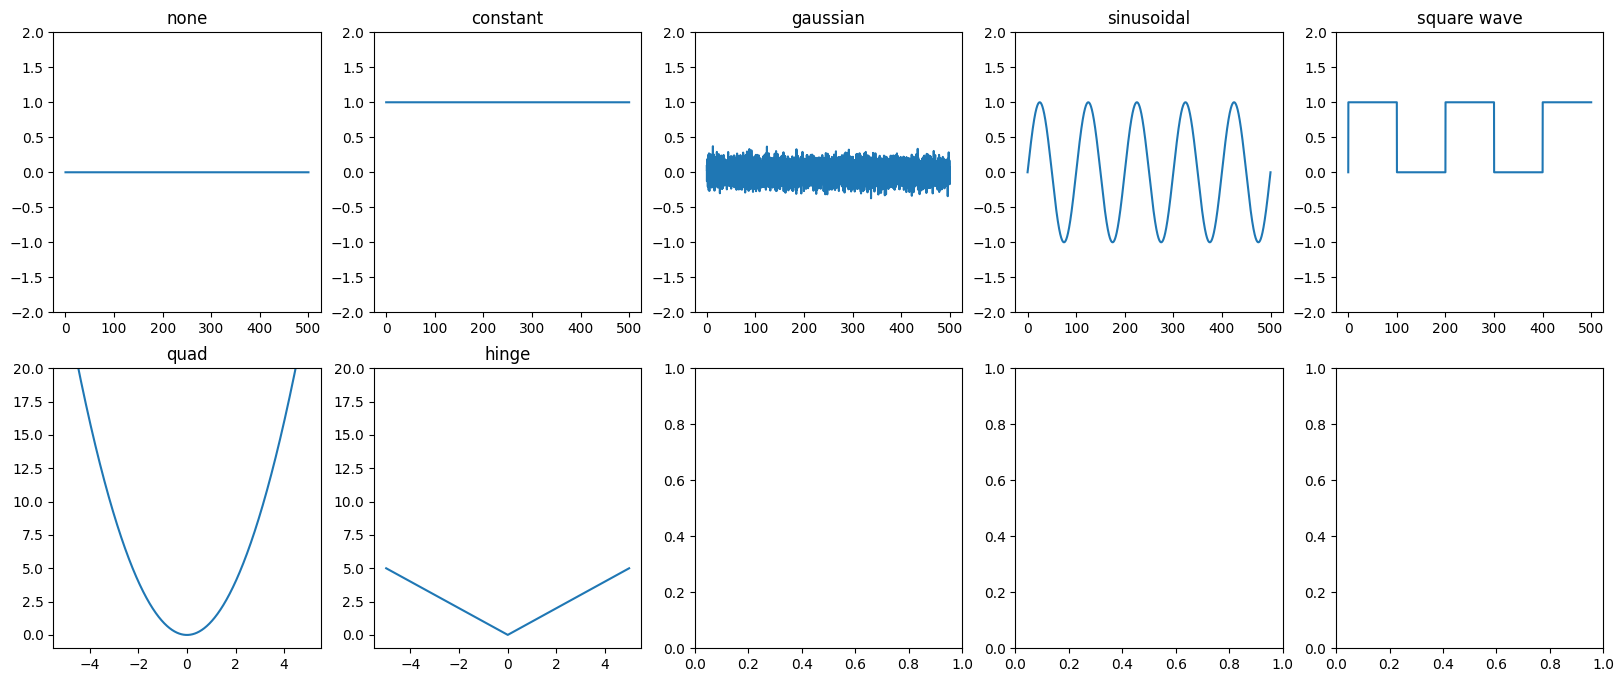

In [2]:
disturbance_fns = {'none': lambda t: 0.,
                   'constant': lambda t: 1.,
                   'gaussian': lambda t: np.random.randn() * 0.1,  # variance of 0.01
#                    'linear': lambda t: float(t),  # this one is stupid
                   'sinusoidal': lambda t: np.sin(2 * np.pi * t / 100),  # period of 100 steps
                   'square wave': lambda t: np.ceil(t / 100) % 2  # period of 40
                  }

cost_fns = {'quad': lambda x, u: jnp.dot(x, x) + jnp.dot(u, u),
            'hinge': lambda x, u: jnp.sum(jnp.abs(x)) + jnp.sum(jnp.abs(u))}

num_points = 10000
fig, ax = plt.subplots(2, len(disturbance_fns), figsize=(4 * len(disturbance_fns), 8))
for i, (k, fn) in enumerate(disturbance_fns.items()):
    xs = np.linspace(0, 500, num_points)
    ax[0, i].plot(xs, [fn(t) for t in xs])
    ax[0, i].set_ylim(-2, 2)
    ax[0, i].set_title(k)
for i, (k, fn) in enumerate(cost_fns.items()):
    xs = np.linspace(-5, 5, num_points)
    ax[1, i].plot(xs, [fn(t, 0) for t in xs])
    ax[1, i].set_ylim(-1, 20)
    ax[1, i].set_title(k)    
plt.show()

## Hyperparameters

In [25]:
disturbance_type = 'square wave'
name = 'lds_{}'.format(disturbance_type)
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 6000  # total timesteps
    T0 = 200  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # how often to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 2  # control dim
    ds = 6  # state dim
    dl = 10  # "state" dim, i.e. dim we lift to

    cost_fn = 'quad'

    make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)
#     observable = TimeDelayedObservation(hh = 1, state_dim=ds, control_dim=du, use_states=True, use_costs=True, use_controls=True, use_time=True)
#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED)
    observable = FullObservation(state_dim=ds)
    do = observable.obs_dim

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_args = {
        'obs_dim': do,
        'control_dim': du,
        
        'max_traj_len': int(1e6),
        'exploration_scale': 0.5,

        'depth': 8,
        'num_epochs': 250,
        'batch_size': 1024,
        'lr': 0.001,
        
        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.0002, betas=(0.99, 0.999))

    evan_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0.2, 0.2, 0.),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': True,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
        'LQR': lambda sys: LQR(A=sys.A, B=sys.B, seed=CONTROLLER_SEED),
#         'HINF': lambda sys: HINF(A=sys.A, B=sys.B, T=T, seed=CONTROLLER_SEED),
        'GPC': lambda sys: GPC(A=sys.A, B=sys.B, H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
#         'BPC': lambda sys: BPC(A=sys.A, B=sys.B, H=h, lr_scale=0.01, decay=True, delta=0.001, seed=CONTROLLER_SEED),
        'RBPC': lambda sys: RBPC(A=sys.A, B=sys.B, M=h, lr=0.02, delta=0.001, noise_sd=0.05, seed=CONTROLLER_SEED),
        'Evan BPC': lambda sys: EvanBPC(A=sys.A, B=sys.B, **evan_bpc_args)
        
#         'Linear': lambda sys: OfflineSysid(EvanBPC(**evan_bpc_args), T0),
#         'Lifted': lambda sys: OfflineSysid(EvanBPC(**evan_bpc_args), T0)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [26]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing LQR
INFO: (LDS): initial state is [ 1.2463559  -0.5722423  -1.4837056   0.13737531 -1.3795713   0.31873566]
 48%|██████████████████████████████████████▉                                          | 2883/6000 [00:02<00:02, 1466.07it/s, control=[0. 0.], cost=0]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1448.96it/s, control=[0. 0.], cost=0]
INFO: 
INFO: (EXPERIMENT): tes

In [ ]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [27]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'true states', label=method, plot_norm=True)
        stats.plot(ax[2, 1], 'controls', label=method, plot_norm=True)
        stats.plot(ax[1, 0], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[1, 1], 'costs', label=method)
    
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method, plot_idx=0)
        stats.plot(i_ax, '-K @ state', label='K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 1]; _ax.set_title('controls'); _ax.legend()
    pass

### Plot

<Figure size 640x480 with 0 Axes>

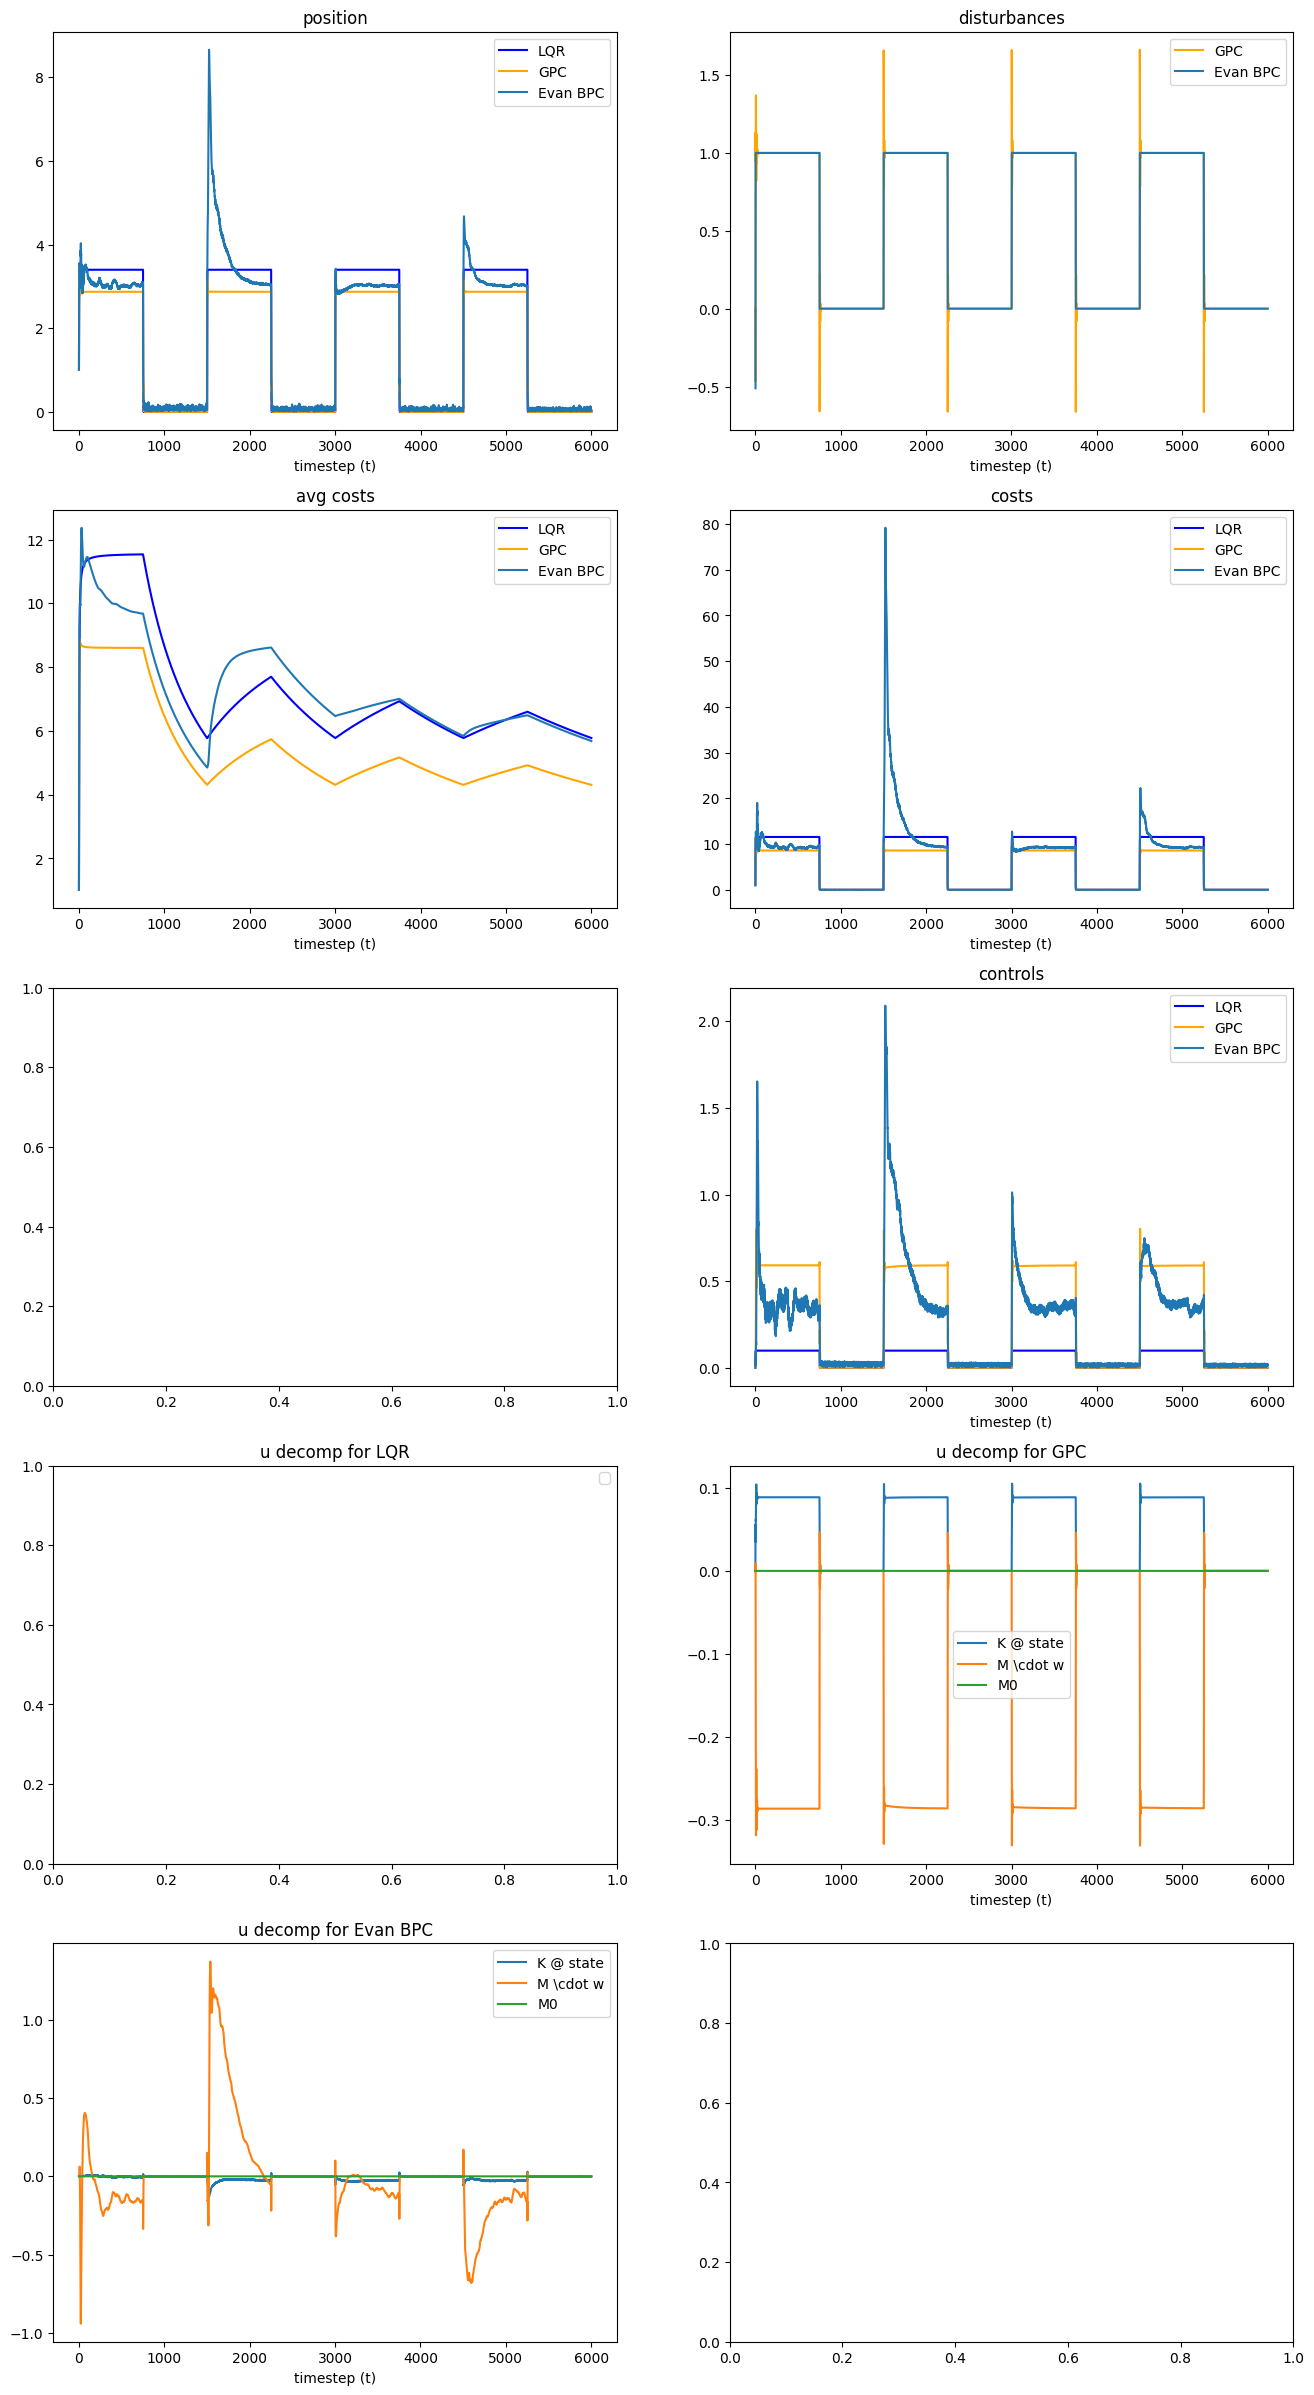

In [28]:
# plot
plot_lds(experiment)

### Dynamic Plot

In [ ]:
# dynamic plot
anim = render(experiment, 'disturbance norms', 'fs', sliderkey='disturbance norms', save_path=None, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)